In [1]:
import numpy as np 
import tensorflow as tf

# import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [3]:
latent_dim = 20
input_size =784
hidden_size = 500

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 784])

In [7]:
# encoder nerwork
W1 = weight_variable([input_size, hidden_size])
b1 = bias_variable([hidden_size])
h1 = tf.nn.relu(tf.matmul(x, W1) + b1)

In [9]:
# get mean and variance
W_hidden_mean = weight_variable([hidden_size, latent_dim])
b_hidden_mean = bias_variable([latent_dim])
hidden_mean = tf.matmul(h1,W_hidden_mean) + b_hidden_mean

In [11]:
W_hidden_sigma = weight_variable([hidden_size, latent_dim])
b_hidden_sigma = bias_variable([latent_dim])
hidden_log_sigma_sqr = tf.matmul(h1, W_hidden_sigma) + b_hidden_sigma

In [12]:
eps = tf.random_normal(tf.shape(hidden_log_sigma_sqr),0,1,dtype=tf.float32)
hidden_sample = hidden_mean + tf.multiply(tf.sqrt(tf.exp(hidden_log_sigma_sqr)),eps)

In [13]:
# decoder network - map the hidden sample to an output of size = image size
W3 = weight_variable([latent_dim,hidden_size])
b3 = bias_variable([hidden_size])
h3 = tf.nn.sigmoid(tf.matmul(hidden_sample, W3) + b3)
W4 = weight_variable([hidden_size,hidden_size])
b4 = bias_variable([hidden_size])
h4 = tf.nn.sigmoid(tf.matmul(h3,W4) + b4)

# output x_hat, the reconstruction mean
W_out = weight_variable([hidden_size,input_size])
b_out = bias_variable([input_size])
x_hat = tf.nn.sigmoid(tf.matmul(h4, W_out) + b_out)

In [14]:
# reconstruction loss is squared error between reconstruction and image (MLE in N(mu(x),sigma^2 I))
reconstruction_loss = tf.reduce_sum(tf.square(x-x_hat)/0.5,1)

In [15]:
# KL divegence between the approximate posterior and prior
kl_divergence = -0.5 * tf.reduce_sum(1 + hidden_log_sigma_sqr - tf.square(hidden_mean) - tf.exp(hidden_log_sigma_sqr), 1)

In [16]:
# avg_loss is the mean across images x in the batch
loss = tf.reduce_mean(reconstruction_loss + kl_divergence);

# train step
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [17]:
# saver to save model
saver = tf.train.Saver()

# train network
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
n_samples = mnist.train.num_examples
# Training cycle
training_epochs = 50
batch_size = 100
display_step = 1
for epoch in range(training_epochs):
    avg_loss = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        x_batch = mnist.train.next_batch(batch_size)
        current_loss = loss.eval(feed_dict={x:x_batch[0]}) #/ n_samples * batch_size
        # Compute average loss
        avg_loss += current_loss / n_samples * batch_size
        # Fit training using batch data
        train_step.run(feed_dict={x: x_batch[0]})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), 
            "loss=", "{:.9f}".format(avg_loss))

Epoch: 0001 loss= 100.833400629
Epoch: 0002 loss= 71.656700918
Epoch: 0003 loss= 61.971127916
Epoch: 0004 loss= 57.592228581
Epoch: 0005 loss= 54.742451019
Epoch: 0006 loss= 52.465270941
Epoch: 0007 loss= 50.722127762
Epoch: 0008 loss= 49.504007998
Epoch: 0009 loss= 48.597170639
Epoch: 0010 loss= 47.804455400
Epoch: 0011 loss= 47.193981628
Epoch: 0012 loss= 46.655130095
Epoch: 0013 loss= 46.210153691
Epoch: 0014 loss= 45.784155939
Epoch: 0015 loss= 45.371744114
Epoch: 0016 loss= 45.037142285
Epoch: 0017 loss= 44.744637867
Epoch: 0018 loss= 44.513741622
Epoch: 0019 loss= 44.228405353
Epoch: 0020 loss= 44.056130281
Epoch: 0021 loss= 43.877567215
Epoch: 0022 loss= 43.652985035
Epoch: 0023 loss= 43.500230602
Epoch: 0024 loss= 43.328686829
Epoch: 0025 loss= 43.178685740
Epoch: 0026 loss= 43.035439737
Epoch: 0027 loss= 42.914665985
Epoch: 0028 loss= 42.773312205


KeyboardInterrupt: 

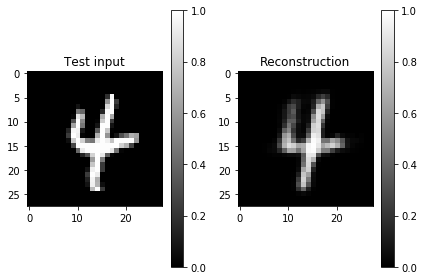

In [28]:
# reconstruct
import matplotlib.pyplot as plt
%matplotlib inline
x_sample = mnist.test.next_batch(1)[0]
x_reconstruct = x_hat.eval(feed_dict={x:x_sample})
plt.figure
plt.subplot(1, 2, 1)
plt.imshow(x_sample.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
plt.title("Test input")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(x_reconstruct.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
plt.title("Reconstruction")
plt.colorbar()
plt.tight_layout()